In [204]:
import numpy as np
class Scheduler:
    'abstract class, interface for scheduler'
    
    def __init__(self,*args,**kwargs):
        pass


    def get_k(self,epoch):
        raise NotImplementedError

    def get_num_segments(self,epoch):
        k = self.get_k(epoch)
        k = int(k)
        if k > 64:
            return 9999
        elif k < 1:
            return 1
        else:
            return k


class PiecewiseScheduler(Scheduler):
    
    def __init__(self,epochs,values):
        '''
        epoch: int[] 
        values: int[]
        Use k = values[i] from epochs[i]
        '''
        self.config = list(zip(epochs,values))


    def get_k(self,epoch):
        _,k = self.config[0]
        for e,v in self.config:
            if e <= epoch:
                k = v
        return k


class LinearScheduler(Scheduler):
    
    def __init__(self,epochs,values):
        '''
        epoch: int[] 
        values: int[]
        Use k = values[i] until epochs[i]
        '''
        self.config = list(zip(epochs,values))
        self.epochs = epochs
        self.values = values
        self.start = self.epochs[0]
        self.end = self.epochs[-1]
        assert len(epochs)>=2, 'need to have more than two points for linear function'
        self.start_slope = self.get_slope(0,1)
        self.end_slope = self.get_slope(-2,-1)

    def get_slope(self,start,end):
        return  (self.values[end] -self.values[start] )/ (self.epochs[end] - self.epochs[start])

    def get_k(self,epoch):
        start,end = self.epochs[0],self.epochs[-1]
        if epoch <= start:
            return self.values[0]- self.start_slope * (start - epoch)
        if epoch >= end:
            return self.values[-1] + self.end_slope * (epoch - end)
        start_idx = 0
        end_idx = 1
        while epoch > self.epochs[end_idx]:
            start_idx += 1
            end_idx += 1
        a,b = self.epochs[start_idx],self.epochs[end_idx]
        slope = self.get_slope(start_idx,end_idx)
        return  self.values[start_idx] + slope * (epoch - self.epochs[start_idx])

        
class ConstantScheduler(Scheduler):
    def __init__(self,epochs,values):
        self.value = values[0]

    def get_k(self,epoch):
        return self.value


class CosineScheduler(Scheduler):
    def __init__(self,epochs,values):
        '''
        epoch: int[] 
        values: int[]
        '''
        self.config = list(zip(epochs,values))
        assert len(epochs) == len(values) and len(values) == 2
        self.start_val,self.end_val = values
        self.start,self.end = epochs
        assert self.end  > self.start
        if self.end_val > self.start_val:
            self.sign = 1
            self.max = self.end_val
            self.min = self.start_val
        else:
            self.sign = -1
            self.max = self.start_val
            self.min = self.end_val

    def get_k(self,epoch):
        if epoch <= self.start:
            return self.start_val
        if epoch >= self.end:
            return self.end_val
        #print("CC")
        pi_2 =  np.pi / 2
        x = (epoch - self.start) / (self.end - self.start) * pi_2
        if self.sign == 1:
            x = pi_2 - x
        k = np.cos(x) * (self.max- self.min) + self.min
        
        return k

SCHEDULERS = {
    'constant':ConstantScheduler,
    'piecewise':PiecewiseScheduler,
    'linear':LinearScheduler,
    'cosine':CosineScheduler
}

def build_Scheduler(config):
    #cluster_config = config['clustering']['scheduler']
    cluster_config = config
    scheduler_type = cluster_config['type']
    assert scheduler_type in SCHEDULERS, "INVALID SCHEDULE TYPE"
    scheduler_class = SCHEDULERS[scheduler_type]
    epochs = cluster_config['epochs']
    values = cluster_config['values']
    return scheduler_class(epochs,values)

In [219]:
# config = {
#     "type":"cosine",
#     "epochs":[0,300],
#     "values":[64,1] # [1,64] work as well
# }
# # config = {
# #     "type":"piecewise",
# #     "epochs":[0,150,300],
# #     "values":[1,64,32] # 0-150:1 ,150-300:64,300-inf:32
# # }
# # config = {
# #     "type":"linear",
# #     "epochs":[0,150,300],
# #     "values":[1,64,32]
# # }

In [220]:
from matplotlib import pyplot as plt

In [221]:
scheduler = build_Scheduler(config)

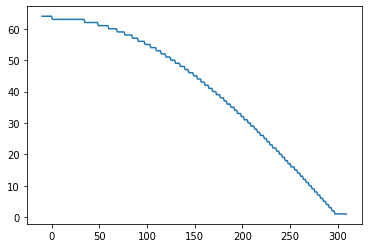

In [222]:
x = range(-10,310)
y = [scheduler.get_num_segments(i) for i in x]
plt.plot(x,y)

In [223]:
scheduler.start_slope

AttributeError: 'CosineScheduler' object has no attribute 'start_slope'